ctrl shift f10 - search commands

# Imports

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib


In [23]:
from tensorflow import keras
from tensorflow.keras import activations, regularizers, layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [24]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(False)

Num GPUs Available:  1


In [25]:
filetype = "Segmented"
diseasename = "Black rot"
numcode = 20

# Getting the data

terminate session - ram disk 3 dots, manage session, terminate

In [26]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [27]:
!unzip '/content/gdrive/MyDrive/Project Final year/Grapes_1.zip'

Archive:  /content/gdrive/MyDrive/Project Final year/Grapes_1.zip
replace Grapes_1/Test/Color/Black rot/High/191__Color__Black rot__High.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# temp - count

In [28]:
xpath = '/content/Grapes_1/Train/'+ filetype + '/Healthy/No label'
data_dir = pathlib.Path(xpath)
print(len(list(data_dir.glob('*'))))


380


In [29]:
xpath = '/content/Grapes_1/Train/'

In [30]:
import os
c = 0
for folder, subfolders, filenames in os.walk(xpath):
    c += len(filenames)
print(c)

4580


# Some functions

In [31]:
def get_label(file_path, class_names):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The fourth to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)



In [32]:
def decode_img(img, img_height, img_width):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])


In [33]:
def process_path(file_path):
  label = get_label(file_path, class_names)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img, img_height, img_width)
  return img, label


In [34]:
def getfiles(srcpath):
  lfiles = []
  for fol, subfol, files in os.walk(srcpath):
    for file in files:
      lfiles.append(os.path.join(srcpath, os.path.relpath(file)))
  return lfiles

In [35]:
def getinput(src, image_count):
  list_ds = tf.data.Dataset.list_files(str(src), shuffle=True)
  list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True)
  val_size = int(image_count * 0.2)
  print(src, 'val size', val_size)
  train_ds = list_ds.skip(val_size)
  val_ds = list_ds.take(val_size)
  print(src, '# train', tf.data.experimental.cardinality(train_ds).numpy())
  print(src, '# test', tf.data.experimental.cardinality(val_ds).numpy())


In [36]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [37]:
def pred(imgpath):
  img = tf.keras.utils.load_img(
      os.path.abspath(imgpath), target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = head_model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      " {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )
  return class_names[np.argmax(score)]

In [38]:
def test_acc(srcpath, classlabel):
  c = 0
  for i in srcpath:
    # print(i, pred(i), classlabel)
    if classlabel == pred(i):
      c += 1
  return c

# Some parameters

In [39]:
batch_size = 32
img_height = 229
img_width = 229


In [40]:
xpath = '/content/Grapes_1/Train/'+ filetype + "/" + diseasename
data_dir = pathlib.Path(xpath)
print(len(list(data_dir.glob('*'))))


2


# Preparing data

In [41]:
image_count = 190 * 2
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=True)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True)

In [42]:
for f in list_ds.take(5):
  print(f.numpy())


b'/content/Grapes_1/Train/Segmented/Black rot/High/185__Segmented__Black rot__High.JPG'
b'/content/Grapes_1/Train/Segmented/Black rot/Low/126__Segmented__Black rot__Low.JPG'
b'/content/Grapes_1/Train/Segmented/Black rot/Low/27__Segmented__Black rot__Low.JPG'
b'/content/Grapes_1/Train/Segmented/Black rot/Low/89__Segmented__Black rot__Low.JPG'
b'/content/Grapes_1/Train/Segmented/Black rot/High/98__Segmented__Black rot__High.JPG'


In [43]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)


['High' 'Low']


In [44]:
val_size = int(image_count * 0.2)
print(val_size)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)


76


In [45]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.dataset_ops.SkipDataset'>


In [46]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())


304
76


# Standardize the data

In [47]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [48]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE).shuffle(buffer_size= image_count )
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [49]:
height_factor = [0, 0.1] # between 20%, 30%
width_factor = [0, 0.1]
layer_zoom = tf.keras.layers.RandomZoom(
    height_factor, width_factor=None, fill_mode='reflect',
    interpolation='bilinear', seed=None, fill_value=0.0
)
train_ds = train_ds.map(lambda x, y: (layer_zoom(x), y))
val_ds = val_ds.map(lambda x, y: (layer_zoom(x), y))

factor = [0, 0.05]
layer_rot = tf.keras.layers.RandomRotation(
    factor, fill_mode='reflect', interpolation='bilinear',
    seed=None, fill_value=0.0
)
train_ds = train_ds.map(lambda x, y: (layer_rot(x), y))
val_ds = val_ds.map(lambda x, y: (layer_rot(x), y))



In [50]:
layer_train = tf.keras.layers.experimental.preprocessing.Normalization(axis=None)
train_ds = train_ds.map(lambda x, y: (layer_train(x), y))
val_ds = val_ds.map(lambda x, y: (layer_train(x), y))

In [51]:
for image, label in train_ds.take(5):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (229, 229, 3)
Label:  1
Image shape:  (229, 229, 3)
Label:  1
Image shape:  (229, 229, 3)
Label:  1
Image shape:  (229, 229, 3)
Label:  1
Image shape:  (229, 229, 3)
Label:  0


# Model

In [52]:
base_model = tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False, weights='imagenet', classes=class_names, input_shape = (img_height, img_width, 3)
)

# tf.keras.applications.efficientnet.EfficientNetB1(
#     include_top=True, weights='imagenet', input_tensor=None,
#     input_shape=None, pooling=None, classes=1000,
#     classifier_activation='softmax', **kwargs
# )


27033600/27018416 [==============================] - 1s 0us/step


In [53]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(len(class_names), activation = 'softmax')(x)

head_model = Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [54]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

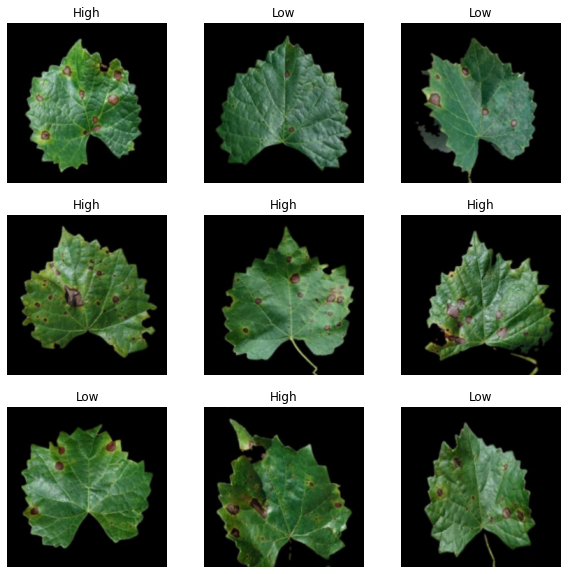

In [55]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")


# Train

In [56]:
epochs=50
history = head_model.fit(train_ds, batch_size = batch_size, epochs=epochs, validation_data=val_ds)

Epoch 1/50
10/10 [==============================] - 42s 2s/step - loss: 20.0438 - accuracy: 0.4770 - val_loss: 0.6838 - val_accuracy: 0.5263
Epoch 2/50
10/10 [==============================] - 9s 944ms/step - loss: 0.5237 - accuracy: 0.7895 - val_loss: 0.5872 - val_accuracy: 0.7763
Epoch 3/50
10/10 [==============================] - 9s 938ms/step - loss: 0.3098 - accuracy: 0.8717 - val_loss: 0.4793 - val_accuracy: 0.8289
Epoch 4/50
10/10 [==============================] - 9s 940ms/step - loss: 0.1985 - accuracy: 0.9309 - val_loss: 0.3904 - val_accuracy: 0.8684
Epoch 5/50
10/10 [==============================] - 9s 937ms/step - loss: 0.1154 - accuracy: 0.9539 - val_loss: 0.3439 - val_accuracy: 0.8421
Epoch 6/50
10/10 [==============================] - 9s 941ms/step - loss: 0.0591 - accuracy: 0.9803 - val_loss: 0.5481 - val_accuracy: 0.7237
Epoch 7/50
10/10 [==============================] - 9s 934ms/step - loss: 0.0657 - accuracy: 0.9704 - val_loss: 0.3850 - val_accuracy: 0.8026
Epoch 8

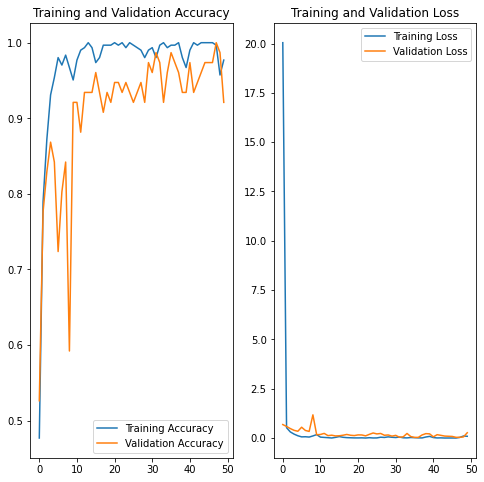

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [58]:
print(acc, val_acc)

[0.47697368264198303, 0.7894737124443054, 0.8717105388641357, 0.9309210777282715, 0.9539473652839661, 0.9802631735801697, 0.9703947305679321, 0.9835526347160339, 0.9671052694320679, 0.9506579041481018, 0.9769737124443054, 0.9901315569877625, 0.9934210777282715, 1.0, 0.9934210777282715, 0.9736841917037964, 0.9802631735801697, 0.9967105388641357, 0.9967105388641357, 0.9967105388641357, 1.0, 0.9967105388641357, 1.0, 0.9934210777282715, 1.0, 0.9967105388641357, 0.9934210777282715, 0.9901315569877625, 0.9802631735801697, 0.9901315569877625, 0.9934210777282715, 0.9802631735801697, 0.9967105388641357, 1.0, 0.9934210777282715, 0.9967105388641357, 0.9967105388641357, 1.0, 0.9802631735801697, 0.9671052694320679, 0.9901315569877625, 1.0, 0.9967105388641357, 1.0, 1.0, 1.0, 1.0, 0.9967105388641357, 0.9572368264198303, 0.9769737124443054] [0.5263158082962036, 0.7763158082962036, 0.8289473652839661, 0.8684210777282715, 0.8421052694320679, 0.7236841917037964, 0.8026315569877625, 0.8421052694320679, 0.

# Save and load methods

In [77]:
head_model.save('HL_'+diseasename+'_1_Segmented.h5')
head_model.save_weights('./checkpoints/HighLow/'+diseasename+'/my_checkpoint_HL_'+diseasename+'_1_Segmented')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [78]:
head_model.save('/content/gdrive/MyDrive/HL_'+diseasename+'_1_Segmented.h5')
head_model.save_weights('/content/gdrive/MyDrive/'+diseasename+'/checkpoints/HighLow/my_checkpoint_HL_'+diseasename+'_1_Segmented')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [61]:
# # Save the weights
# head_model.save_weights('./checkpoints/my_checkpoint'+ str(numcode) +'_1_densenet_'+ filetype )

# create model ==> basemodel==>head model

# # Restore the weights
# headmodel.load_weights('./checkpoints/my_checkpoint1...')


# Test

In [62]:
tpath = '/content/Grapes_1/Test/'+ filetype + '/'+diseasename+'/Low/199__'+ filetype + '__'+diseasename+'__Low.JPG'
img = tf.keras.utils.load_img(
    tpath, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = head_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to Low with a 59.49 percent confidence.


In [63]:
print(score)

tf.Tensor([0.40511245 0.59488755], shape=(2,), dtype=float32)


In [69]:
diseases = ['Black rot']
imgtypes = [ filetype ]
# imgtypes = ['Color', 'GrayScale', 'Segmented']
severity = ['Low', 'High']
filesdict = {}
for disease in diseases:
  for imgtype in imgtypes:
    for sev in severity:
      srcpath = os.path.join(r'/content/Grapes_1/Test', imgtype+ "//"+disease+"//"+ sev)
      # print(getfiles(srcpath))
      filesdict[disease+imgtype+sev] = [sev, getfiles(srcpath)]

In [70]:
for k, v in filesdict.items():
  count_ = test_acc(v[1], v[0])
  print(k, count_, count_/len(v))

 Low with a 54.62 percent confidence.
 Low with a 67.31 percent confidence.
 Low with a 70.18 percent confidence.
 Low with a 59.67 percent confidence.
 Low with a 54.95 percent confidence.
 Low with a 58.65 percent confidence.
 Low with a 62.20 percent confidence.
 High with a 66.67 percent confidence.
 Low with a 72.31 percent confidence.
 Low with a 65.41 percent confidence.
 Low with a 53.53 percent confidence.
 Low with a 62.34 percent confidence.
 Low with a 68.14 percent confidence.
 Low with a 59.49 percent confidence.
 High with a 65.67 percent confidence.
 Low with a 52.87 percent confidence.
 High with a 62.64 percent confidence.
 Low with a 59.47 percent confidence.
 Low with a 58.41 percent confidence.
 Low with a 72.46 percent confidence.
Black rotSegmentedLow 17 8.5
 High with a 69.78 percent confidence.
 High with a 71.93 percent confidence.
 High with a 69.65 percent confidence.
 High with a 72.11 percent confidence.
 High with a 72.92 percent confidence.
 High with a 

In [76]:
!tar -czvf HL_Blackrot_1_Segmented.tar.gz  '/content/checkpoints/HighLow/Blackrot/'

tar: Removing leading `/' from member names
tar: /content/checkpoints/HighLow/Blackrot: Cannot stat: No such file or directory
tar: Exiting with failure status due to previous errors


In [75]:
!tar -czvf HL_Blackrot_1_Segmented.tar.gz  '/content/HL_Black rot_1_Segmented.h5'

tar: Removing leading `/' from member names
/content/HL_Black rot_1_Segmented.h5


In [68]:
# from google.colab import files
# files.download('final20modelDensenet.tar.gz')
# files.download('final20modelDensenet_h5.tar.gz')